# Building a Lyme Disease Dataset 2000-2021

<p>We build a dataset of over 5600 abstracts relating to Lyme Disease using a combination of Publish or Perish searches, web scraping and python processing. The compete acquisition process is outlined from start to finish in this notebook and summarised in the PRISMA diagram below.</p>

![PrismaDiagram](PRISMADiag.png)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-and-Defaults" data-toc-modified-id="Imports-and-Defaults-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports and Defaults</a></span></li></ul></li><li><span><a href="#Identification" data-toc-modified-id="Identification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Identification</a></span><ul class="toc-item"><li><span><a href="#Accessing-Publish-or-Perish-with-Command-Line-Prompts" data-toc-modified-id="Accessing-Publish-or-Perish-with-Command-Line-Prompts-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Accessing Publish or Perish with Command Line Prompts</a></span></li><li><span><a href="#Importing-search-results" data-toc-modified-id="Importing-search-results-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Importing search results</a></span></li><li><span><a href="#Dropping-Records-without-a-DOI" data-toc-modified-id="Dropping-Records-without-a-DOI-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Dropping Records without a DOI</a></span></li><li><span><a href="#Dropping-Duplicates" data-toc-modified-id="Dropping-Duplicates-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Dropping Duplicates</a></span></li></ul></li><li><span><a href="#Screening" data-toc-modified-id="Screening-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Screening</a></span><ul class="toc-item"><li><span><a href="#Restricting-to-journal-articles" data-toc-modified-id="Restricting-to-journal-articles-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Restricting to journal articles</a></span></li><li><span><a href="#Removing-records-with-missing-Publication-Name-or-Article-Title" data-toc-modified-id="Removing-records-with-missing-Publication-Name-or-Article-Title-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Removing records with missing Publication Name or Article Title</a></span></li><li><span><a href="#Removing-incomplete-Google-Scholar-Journal-Names-that-can't-be-matched-and-completed" data-toc-modified-id="Removing-incomplete-Google-Scholar-Journal-Names-that-can't-be-matched-and-completed-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Removing incomplete Google Scholar Journal Names that can't be matched and completed</a></span></li><li><span><a href="#Preparation-for-Merging-Remaining-Records" data-toc-modified-id="Preparation-for-Merging-Remaining-Records-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Preparation for Merging Remaining Records</a></span><ul class="toc-item"><li><span><a href="#Resetting-very-short-abstracts" data-toc-modified-id="Resetting-very-short-abstracts-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Resetting very short abstracts</a></span></li><li><span><a href="#Dummy-for-Source" data-toc-modified-id="Dummy-for-Source-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Dummy for Source</a></span></li></ul></li><li><span><a href="#Building-Dataframes-of-Unique-Records" data-toc-modified-id="Building-Dataframes-of-Unique-Records-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Building Dataframes of Unique Records</a></span><ul class="toc-item"><li><span><a href="#Records-that-have-DOI-and-abstract" data-toc-modified-id="Records-that-have-DOI-and-abstract-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Records that have DOI and abstract</a></span></li><li><span><a href="#Records-that-have-DOI-but-no-abstract" data-toc-modified-id="Records-that-have-DOI-but-no-abstract-2.5.2"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Records that have DOI but no abstract</a></span></li><li><span><a href="#Summary-of-Merged-Dataframes" data-toc-modified-id="Summary-of-Merged-Dataframes-2.5.3"><span class="toc-item-num">2.5.3&nbsp;&nbsp;</span>Summary of Merged Dataframes</a></span></li></ul></li><li><span><a href="#Saving-New-Dataframes" data-toc-modified-id="Saving-New-Dataframes-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Saving New Dataframes</a></span></li></ul></li><li><span><a href="#Scraping" data-toc-modified-id="Scraping-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Scraping</a></span><ul class="toc-item"><li><span><a href="#Formatting-Vagaries" data-toc-modified-id="Formatting-Vagaries-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Formatting Vagaries</a></span></li><li><span><a href="#Scraping-Function" data-toc-modified-id="Scraping-Function-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Scraping Function</a></span></li></ul></li><li><span><a href="#Processing-Scraped-Data" data-toc-modified-id="Processing-Scraped-Data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Processing Scraped Data</a></span><ul class="toc-item"><li><span><a href="#Non-Unique-Counts-for-Scraped-Abstracts" data-toc-modified-id="Non-Unique-Counts-for-Scraped-Abstracts-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Non Unique Counts for Scraped Abstracts</a></span></li><li><span><a href="#Removing-extremely-short-'abstracts'" data-toc-modified-id="Removing-extremely-short-'abstracts'-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Removing extremely short 'abstracts'</a></span></li><li><span><a href="#Joining-datasets" data-toc-modified-id="Joining-datasets-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Joining datasets</a></span></li><li><span><a href="#Cleaning-Text" data-toc-modified-id="Cleaning-Text-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Cleaning Text</a></span></li><li><span><a href="#Abstract-Lengths---Identifying-and-Handling-Outliers" data-toc-modified-id="Abstract-Lengths---Identifying-and-Handling-Outliers-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Abstract Lengths - Identifying and Handling Outliers</a></span><ul class="toc-item"><li><span><a href="#Handling-Outliers-in-Batches" data-toc-modified-id="Handling-Outliers-in-Batches-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Handling Outliers in Batches</a></span></li></ul></li></ul></li><li><span><a href="#Assessing-All-Abstracts-for-Eligibility" data-toc-modified-id="Assessing-All-Abstracts-for-Eligibility-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Assessing All Abstracts for Eligibility</a></span><ul class="toc-item"><li><span><a href="#Removing-Non-English-Abstracts" data-toc-modified-id="Removing-Non-English-Abstracts-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Removing Non-English Abstracts</a></span></li><li><span><a href="#Removing-Records-with-no-Relevant-Terms-in-Title-or-Abstract" data-toc-modified-id="Removing-Records-with-no-Relevant-Terms-in-Title-or-Abstract-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Removing Records with no Relevant Terms in Title or Abstract</a></span></li><li><span><a href="#Removing-Non-Journal-Abstracts" data-toc-modified-id="Removing-Non-Journal-Abstracts-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Removing Non-Journal Abstracts</a></span></li></ul></li><li><span><a href="#Saving-Complete-Dataset" data-toc-modified-id="Saving-Complete-Dataset-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Saving Complete Dataset</a></span></li></ul></div>

### Imports and Defaults

In [1]:
from IPython.core.display import display, HTML, Markdown as md
display(HTML("""<style>.container { width:75% !important; } p, ul {max-width: 40em;} .rendered_html table { margin-left: 0; } .output_subarea.output_png { display: flex; justify-content: center;}</style>"""))

In [2]:
# Basics
import numpy as np 
import pandas as pd 

#String cleaning and processing
import re
import string

import os
pd.options.mode.chained_assignment = None

import json

In [3]:
# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18

In [4]:
from langdetect import detect #language detection

In [5]:
import unicodedata

## Identification

<p>Publish or Perish (PoP) software (either via desktop GUI or command line prompts) was used to search through four research databases (Google Scholar, Scopus, PubMed and CrossRef). The searches were done year by year to maximise the number of records returned and then joined together into four separate datasets. </p> 
<p>The search terms used were "Lyme disease" in each case apart from CrossRef, where "Lyme" was used due to the implicit "or" used in the search mechanism for that database.</p>
<p>The maximum number of results returned for each search (by year) was 1000 but only in the case of Google Scholar did the search fill the quota. The others stopped when no further relevant records could be found.</p>
<p>Due to limitations on the number of requests that could be made to Google Scholar and the risk of being locked out, Google Scholar searches were conducted via the PoP GUI whilst the others could be automated via command line prompts executed via this Jupyter notebook.</p>

### Accessing Publish or Perish with Command Line Prompts

Included below for reference. Google Scholar search conducted via Publish or Perish GUI.

In [6]:
# #searching pubmed year by year through command line access
# for year in range (2000, 2022):
#     outfile = 'pubmed-'+str(year)+'.json'
#     yr = str(year)+'-'+str(year)
#     !pop7query --pubmed --keywords 'lyme disease' --max 1000 --years $yr $outfile

In [7]:
# #searching crossref year by year through command line access
# for year in range (2000, 2022):
#     outfile = 'crossref-'+str(year)+'.json'
#     yr = str(year)+'-'+str(year)
#     !pop7query --crossref --keywords 'lyme' --max 1000 --years $yr $outfile

In [8]:
# #searching scopus year by year through command line access
# for year in range (2000, 2022):
#     outfile = 'scopus-LD-'+str(year)+'.json'
#     yr = str(year)+'-'+str(year)
#     !pop7query --scopus --keywords 'lyme disease' --max 1000 --years $yr $outfile

### Importing search results

<p>Over 40,000 records were returned from the four databases covering the 22-year search period. The JSON files (one per year per database) are loaded into four dataframes </p>

In [9]:
def loadJSONfiles(path, source, startYear, endYear):
    JSONobject = []
    for year in range(startYear, endYear+1):
        filename= path + source+'-'+str(year)+'.json'
        if os.path.exists(filename):
            with open(filename, encoding='utf-8-sig') as f:
                newfile = json.load(f)
            JSONobject = JSONobject+ newfile
        else: print('Cant find', filename)
    return JSONobject

In [10]:
def get_df(jsonfile, source):
    df_dict = {'publication':[], 'title':[], 'authors':[],'doi':[], 
               'year':[], 'cites':[],'type':[], 'abstract':[], 
#                'article_url':[], 'fulltext_url':[]
              }
    for record in jsonfile:
        df_dict['publication'].append(record.get('source'))
        df_dict['year'].append(record.get('year'))
        df_dict['doi'].append(record.get('doi'))
        df_dict['title'].append(record.get('title'))
        df_dict['abstract'].append(record.get('abstract'))
        df_dict['authors'].append(record.get('authors'))
        df_dict['cites'].append(record.get('cites'))
        df_dict['type'].append(record.get('type'))
#         df_dict['article_url'].append(record.get('article_url'))
#         df_dict['fulltext_url'].append(record.get('fulltext_url'))
    
    df = pd.DataFrame.from_dict(df_dict)
    df.fillna(np.nan, inplace=True)
    df['abstractLength'] = [len(x) if type(x)==str else np.nan for x in df['abstract'] ]
    df[source]=np.int8(1)
    df.reset_index(drop=True, inplace=True)
    return df

In [11]:
def jsonFilesToDF(path, source, startYear, endYear):
    jsonFile = loadJSONfiles(path,source, startYear, endYear)
    df = get_df(jsonFile, source)
    return df

In [12]:
crossref = jsonFilesToDF('POPresults/','crossref', 2000, 2021)
gscholar = jsonFilesToDF('POPresults/','gscholar', 2000, 2021)
pubmed = jsonFilesToDF('POPresults/','pubmed', 2000, 2021)
scopus = jsonFilesToDF('POPresults/','scopus', 2000, 2021)

In [13]:
crossref.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5971 entries, 0 to 5970
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     5874 non-null   object 
 1   title           5971 non-null   object 
 2   authors         5614 non-null   object 
 3   doi             5971 non-null   object 
 4   year            5971 non-null   int64  
 5   cites           5971 non-null   int64  
 6   type            5971 non-null   object 
 7   abstract        922 non-null    object 
 8   abstractLength  922 non-null    float64
 9   crossref        5971 non-null   int8   
dtypes: float64(1), int64(2), int8(1), object(6)
memory usage: 425.8+ KB


In [14]:
gscholar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21700 entries, 0 to 21699
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     18917 non-null  object 
 1   title           21700 non-null  object 
 2   authors         21700 non-null  object 
 3   doi             5030 non-null   object 
 4   year            20472 non-null  float64
 5   cites           21700 non-null  int64  
 6   type            7588 non-null   object 
 7   abstract        20369 non-null  object 
 8   abstractLength  20369 non-null  float64
 9   gscholar        21700 non-null  int8   
dtypes: float64(2), int64(1), int8(1), object(6)
memory usage: 1.5+ MB


In [15]:
pubmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8058 entries, 0 to 8057
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     8058 non-null   object 
 1   title           8055 non-null   object 
 2   authors         7960 non-null   object 
 3   doi             6806 non-null   object 
 4   year            8055 non-null   float64
 5   cites           8058 non-null   int64  
 6   type            8058 non-null   object 
 7   abstract        6752 non-null   object 
 8   abstractLength  6752 non-null   float64
 9   pubmed          8058 non-null   int8   
dtypes: float64(2), int64(1), int8(1), object(6)
memory usage: 574.6+ KB


In [16]:
scopus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     4400 non-null   object 
 1   title           4400 non-null   object 
 2   authors         4391 non-null   object 
 3   doi             4203 non-null   object 
 4   year            4400 non-null   int64  
 5   cites           4400 non-null   int64  
 6   type            4399 non-null   object 
 7   abstract        0 non-null      float64
 8   abstractLength  0 non-null      float64
 9   scopus          4400 non-null   int8   
dtypes: float64(2), int64(2), int8(1), object(5)
memory usage: 313.8+ KB


In [17]:
total = len(crossref)+len(scopus)+len(pubmed)+len(gscholar)
print('Records indentified from databases:', total)

Records indentified from databases: 40129


### Dropping Records without a DOI

<p>A digital object identifier (DOI) is a unique persistent identifier for an object. DOIs are in wide use to identify academic information, such as journal articles, research reports, data sets, and official publications and have been used for other purposes too. In our case the unique nature of a DOI ensure no duplicated records are included in the final data set and their wide use for published academic research help to filter out less relevant records. </p>
<p>For this reason we only include records that have a DOI, and then filter out any records with duplicated DOIs.</p>

In [18]:
crossref = crossref[crossref.doi.notna()]
gscholar = gscholar[gscholar.doi.notna()]
pubmed = pubmed[pubmed.doi.notna()]
scopus = scopus[scopus.doi.notna()]

In [19]:
oldtotal = total
total = len(crossref)+len(scopus)+len(pubmed)+len(gscholar)
print('Records left after dropping records without DOI:', total)
print('Records removed:', oldtotal-total)

Records left after dropping records without DOI: 22010
Records removed: 18119


In [20]:
#standardise case of each doi entry
crossref['doi'] = crossref.doi.str.lower() 
gscholar['doi'] = gscholar.doi.str.lower() 
pubmed['doi'] = pubmed.doi.str.lower()
scopus['doi'] = scopus.doi.str.lower()

# trim any dois that have extended link (i.e. "?" followed by anthing)
# Only some Google Scholar records affected by this 
gscholar['doi'] = gscholar.doi.apply (lambda x: re.split('\?', x)[0]) 

crossref['publication'] = crossref.publication.str.lower() #standardise publication names
gscholar['publication'] = gscholar.publication.str.lower() #standardise publication names
pubmed['publication'] = pubmed.publication.str.lower() #standardise publication names
scopus['publication'] = scopus.publication.str.lower() #standardise publication names

### Dropping Duplicates

In [21]:
crossref.drop_duplicates(subset=['doi'], inplace=True)
gscholar.drop_duplicates(subset=['doi'], inplace=True)
pubmed.drop_duplicates(subset=['doi'], inplace=True)
scopus.drop_duplicates(subset=['doi'], inplace=True)

In [22]:
oldtotal = total
total = len(crossref)+len(scopus)+len(pubmed)+len(gscholar)
print('Records left after droping duplicates:', total)
print('Records removed:', oldtotal-total)

Records left after droping duplicates: 21450
Records removed: 560


In [23]:
crossref.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5960 entries, 0 to 5970
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     5863 non-null   object 
 1   title           5960 non-null   object 
 2   authors         5603 non-null   object 
 3   doi             5960 non-null   object 
 4   year            5960 non-null   int64  
 5   cites           5960 non-null   int64  
 6   type            5960 non-null   object 
 7   abstract        919 non-null    object 
 8   abstractLength  919 non-null    float64
 9   crossref        5960 non-null   int8   
dtypes: float64(1), int64(2), int8(1), object(6)
memory usage: 471.4+ KB


In [24]:
gscholar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4993 entries, 0 to 21674
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     4857 non-null   object 
 1   title           4993 non-null   object 
 2   authors         4993 non-null   object 
 3   doi             4993 non-null   object 
 4   year            4980 non-null   float64
 5   cites           4993 non-null   int64  
 6   type            624 non-null    object 
 7   abstract        4979 non-null   object 
 8   abstractLength  4979 non-null   float64
 9   gscholar        4993 non-null   int8   
dtypes: float64(2), int64(1), int8(1), object(6)
memory usage: 395.0+ KB


In [25]:
pubmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6294 entries, 0 to 8057
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     6294 non-null   object 
 1   title           6293 non-null   object 
 2   authors         6260 non-null   object 
 3   doi             6294 non-null   object 
 4   year            6294 non-null   float64
 5   cites           6294 non-null   int64  
 6   type            6294 non-null   object 
 7   abstract        5394 non-null   object 
 8   abstractLength  5394 non-null   float64
 9   pubmed          6294 non-null   int8   
dtypes: float64(2), int64(1), int8(1), object(6)
memory usage: 497.9+ KB


In [26]:
scopus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4203 entries, 0 to 4399
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     4203 non-null   object 
 1   title           4203 non-null   object 
 2   authors         4198 non-null   object 
 3   doi             4203 non-null   object 
 4   year            4203 non-null   int64  
 5   cites           4203 non-null   int64  
 6   type            4202 non-null   object 
 7   abstract        0 non-null      float64
 8   abstractLength  0 non-null      float64
 9   scopus          4203 non-null   int8   
dtypes: float64(2), int64(2), int8(1), object(5)
memory usage: 332.5+ KB


## Screening

### Restricting to journal articles

<p>The focus of the analysis is on journal articles so we look to exclude records that do not meet that criteria. For Cross Ref ("journal-article"), PubMed ("Journal Article") and Scopus ("Article") the value for "type" as returned by the PoP search is easy to filter on while for Google Scholar, "type" is not as helpful but we can filter out the most unlikley candidates (e.g. "book" or "citation") by restricting to "PDF" or "HTML" </p>

In [27]:
crossref.type.value_counts()

journal-article        5200
book-chapter            530
posted-content           53
dataset                  50
proceedings-article      37
reference-entry          29
book                     20
component                13
peer-review              13
other                     5
report                    4
reference-book            3
monograph                 3
Name: type, dtype: int64

In [28]:
gscholar.type.value_counts()

HTML        526
CITATION     45
PDF          43
BOOK         10
Name: type, dtype: int64

In [29]:
pubmed.type.value_counts()

Journal Article                      4556
Case Reports                          746
Comparative Study                     272
Letter                                189
Comment                               143
English Abstract                       98
Evaluation Study                       85
Editorial                              70
Clinical Trial                         42
News                                   28
Historical Article                     17
Congress                                6
Biography                               6
Introductory Journal Article            5
Consensus Development Conference        5
Review                                  4
Published Erratum                       4
Clinical Study                          3
Guideline                               3
Interview                               2
Patient Education Handout               2
Corrected and Republished Article       1
Clinical Conference                     1
Clinical Trial, Phase II          

In [30]:
scopus.type.value_counts()

Article             3204
Review               784
Conference Paper      58
Short Survey          44
Letter                43
Note                  29
Editorial             18
Book Chapter          16
Book                   3
Erratum                2
Data Paper             1
Name: type, dtype: int64

In [31]:
crossref = crossref[crossref.type =='journal-article']
gscholar = gscholar[gscholar.type.isin(['PDF', 'HTML'])]
pubmed = pubmed[pubmed.type =='Journal Article']
scopus = scopus[scopus.type =='Article']

In [32]:
oldtotal = total
total = len(crossref)+len(scopus)+len(pubmed)+len(gscholar)
print('Records left after dropping non journal articles:', total)
print('Records removed:', oldtotal-total)

Records left after dropping non journal articles: 13529
Records removed: 7921


### Removing records with missing Publication Name or Article Title

<p>Records without titles or publication names may be an indication that a record does not reference a journal article. Additionally, records missing publication names hinder analysis of sentiment or topics across journals. For these reasons, these records are removed.</p>

In [33]:
crossref = crossref[crossref.publication.notna() & crossref.title.notna()]
gscholar = gscholar[gscholar.publication.notna() & gscholar.title.notna()]
pubmed = pubmed[pubmed.publication.notna() & pubmed.title.notna()]
scopus = scopus[scopus.publication.notna() & scopus.title.notna()]

# Also drop any titles comprosed of just numbers
crossref = crossref[crossref.title.str.lower().str.islower()] 
gscholar = gscholar[gscholar.title.str.lower().str.islower()] 
pubmed = pubmed[pubmed.title.str.lower().str.islower()] 
scopus = scopus[scopus.title.str.lower().str.islower()] 

In [34]:
oldtotal = total
total = len(crossref)+len(scopus)+len(pubmed)+len(gscholar)
print('Records left after dropping records with missing journal or article names:', total)
print('Records removed:', oldtotal-total)

Records left after dropping records with missing journal or article names: 13501
Records removed: 28


In [35]:
crossref.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5199 entries, 0 to 5970
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     5199 non-null   object 
 1   title           5199 non-null   object 
 2   authors         5001 non-null   object 
 3   doi             5199 non-null   object 
 4   year            5199 non-null   int64  
 5   cites           5199 non-null   int64  
 6   type            5199 non-null   object 
 7   abstract        819 non-null    object 
 8   abstractLength  819 non-null    float64
 9   crossref        5199 non-null   int8   
dtypes: float64(1), int64(2), int8(1), object(6)
memory usage: 411.2+ KB


In [36]:
gscholar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543 entries, 252 to 21660
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     543 non-null    object 
 1   title           543 non-null    object 
 2   authors         543 non-null    object 
 3   doi             543 non-null    object 
 4   year            543 non-null    float64
 5   cites           543 non-null    int64  
 6   type            543 non-null    object 
 7   abstract        543 non-null    object 
 8   abstractLength  543 non-null    float64
 9   gscholar        543 non-null    int8   
dtypes: float64(2), int64(1), int8(1), object(6)
memory usage: 43.0+ KB


In [37]:
pubmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4555 entries, 0 to 8057
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     4555 non-null   object 
 1   title           4555 non-null   object 
 2   authors         4535 non-null   object 
 3   doi             4555 non-null   object 
 4   year            4555 non-null   float64
 5   cites           4555 non-null   int64  
 6   type            4555 non-null   object 
 7   abstract        4321 non-null   object 
 8   abstractLength  4321 non-null   float64
 9   pubmed          4555 non-null   int8   
dtypes: float64(2), int64(1), int8(1), object(6)
memory usage: 360.3+ KB


In [38]:
scopus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3204 entries, 0 to 4399
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     3204 non-null   object 
 1   title           3204 non-null   object 
 2   authors         3202 non-null   object 
 3   doi             3204 non-null   object 
 4   year            3204 non-null   int64  
 5   cites           3204 non-null   int64  
 6   type            3204 non-null   object 
 7   abstract        0 non-null      float64
 8   abstractLength  0 non-null      float64
 9   scopus          3204 non-null   int8   
dtypes: float64(2), int64(2), int8(1), object(5)
memory usage: 253.4+ KB


### Removing incomplete Google Scholar Journal Names that can't be matched and completed

<p>A number of records sourced from the PoP search of Google Scholar have truncated publication names, starting and/or ending with the '…' character. Similar to section 2.2, including these records 'as is' would affect analysis of sentiment and topic across journals in later stages of the project.</p>
<p>Using the first portion of a DOI number (which is often consistent across articles from the same journal), we match any truncated name with a corresponding full name from elsewhere in the dataset so long as the journal DOIs also match. </p>
<p>Matched journal names are corrected while any records that still have un-matched truncated names are removed</p>

In [39]:
#Splitting out the first portion of DOIs for each record allows for comparison between potential matches of jounral names.
gscholar['doiJournal'] = gscholar.doi.apply (lambda x: re.split('/', x)[0])

In [40]:
incompleteJournalNames = [name for name in gscholar.publication.unique() if '…' in name]
completeJournalNames = [name for name in gscholar.publication.unique() if '…' not in name]

In [41]:
incompleteJournalNames

['the journal of neuropsychiatry and clinical …',
 '… england journal of …',
 'american journal of …',
 'molecular …',
 'the embo …',
 'bmc musculoskeletal …',
 'new england journal of …',
 'journal of the american veterinary …',
 'arthritis res …',
 'international journal of health …',
 'bmc infectious …',
 'weekly releases (1997 …',
 'international …',
 'baylor university medical …',
 'arthritis …',
 'anesthetic and obstetric management of high-risk …',
 'european journal of …',
 '…',
 'medical microbiology …',
 'european journal of clinical microbiology and …',
 'clinical infectious …',
 'current …',
 'epidemiologic perspectives & …',
 'weekly releases …',
 'bmc …',
 'journal of negative …',
 'international journal of …',
 'arthritis research & …',
 'journal of …',
 'bmc veterinary …',
 'european journal of clinical …',
 'malaria …',
 'journal of brachial …',
 'bmc public …',
 '… therapie 2007| 2008',
 'fortschritte der praktischen dermatologie und …',
 'the journal of neuropsychiat

In [42]:
journalNamesDict = {}
for name in completeJournalNames:
    journalNamesDict[name] = gscholar[gscholar.publication ==name].doiJournal.unique()[0]

In [43]:
len(gscholar[gscholar.publication.str.contains('…')])

324

In [44]:
for index, row in gscholar.iterrows():
    if ('…') in row['publication']:
        name = row['publication']
        options=[]
        if name.startswith('…') & name.endswith('…'):
            newname=name[1:-1]
            if len(newname)>1:
                for key in journalNamesDict:
                    if (newname in key) & (journalNamesDict[key]==row['doiJournal']):
                        options.append(key)
                if len(options)==1:
                    gscholar.loc[index,'publication']= options[0]
        elif name.startswith('…'):
            newname=name[1:]
            for key in journalNamesDict:
                if (key.endswith(newname)) & (journalNamesDict[key]==row['doiJournal']):
                    options.append(key)
            if len(options)==1:
                gscholar.loc[index,'publication']= options[0]
        elif name.endswith('…'):
            newname=name[:-1]
            for key in journalNamesDict:
                if (key.startswith(newname)) & (journalNamesDict[key]==row['doiJournal']):
                    options.append(key)
            if len(options)==1:
                gscholar.loc[index,'publication']= options[0]

In [45]:
### Number of records to be removed
len(gscholar[gscholar.publication.str.contains('…')])

155

In [46]:
gscholar=gscholar[~gscholar.publication.str.contains('…')]

In [47]:
gscholar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388 entries, 272 to 21660
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publication     388 non-null    object 
 1   title           388 non-null    object 
 2   authors         388 non-null    object 
 3   doi             388 non-null    object 
 4   year            388 non-null    float64
 5   cites           388 non-null    int64  
 6   type            388 non-null    object 
 7   abstract        388 non-null    object 
 8   abstractLength  388 non-null    float64
 9   gscholar        388 non-null    int8   
 10  doiJournal      388 non-null    object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 33.7+ KB


In [48]:
gscholar.drop(columns='doiJournal', inplace=True)

In [49]:
oldtotal = total
total = len(crossref)+len(scopus)+len(pubmed)+len(gscholar)
print('Records left after dropping truncated Google Scholar journal names:', total)
print('Records removed:', oldtotal-total)

Records left after dropping truncated Google Scholar journal names: 13346
Records removed: 155


### Preparation for Merging Remaining Records

#### Resetting very short abstracts

With the exception of very short pubmed abstracts which upon manual inspection appear to all be correct, there are some abstracts from the other datasets that appear truncated. An arbitrary threshold of 300 characters is set for Scopus, CrossRef and Google Scholar abstracts and any shorter than this are reset to null. These may be properly populated during the scraping process.

In [58]:
for idx in crossref.index:
    if crossref.loc[idx].abstractLength<300:
        crossref.at[idx,'abstract'] = np.NaN
        crossref.at[idx,'abstractLength'] = np.NaN

In [59]:
for idx in scopus.index:
    if scopus.loc[idx].abstractLength<300:
        scopus.at[idx,'abstract'] = np.NaN
        scopus.at[idx,'abstractLength'] = np.NaN

In [60]:
for idx in gscholar.index:
    if gscholar.loc[idx].abstractLength<300:
        gscholar.at[idx,'abstract'] = np.NaN
        gscholar.at[idx,'abstractLength'] = np.NaN

#### Dummy for Source

In [61]:
# Datasets already contain a dummy variable column flagging where they were obtained from. E.g pubmed['pubmed']=1
# This aids matching columns in preparation for concatenation
pubmed[['gscholar','crossref','scopus']]=0
gscholar[['pubmed','crossref','scopus']]=0
crossref[['pubmed','gscholar','scopus']]=0
scopus[['pubmed','gscholar','crossref']]=0

### Building Dataframes of Unique Records

#### Records that have DOI and abstract

In [62]:
len(pubmed[pubmed.doi.notna() & pubmed.abstract.notna()])

4321

<p>Using Pubmed results as the starting point due to their relative completeness of data, we take the 4321 results with both a DOI and abstract and add any abstracts from the Crossref, Google Scholar or Scopus records that also have a unique DOI. Using the DOI as a unique identifier prevents adding duplicates to the new collated dataset as we build it. </p>
<p>After merging those records that have unique DOIs and an abstract we have a total of 4615 records with an existing abstract.</p>

In [63]:
## Splitting Datasets by abstract and doi availability
crossrefToAdd = crossref[crossref.doi.notna() & crossref.abstract.notna()]
crossrefRemaining = crossref[~(crossref.doi.notna() & crossref.abstract.notna())]
gscholarToAdd = gscholar[gscholar.doi.notna() & gscholar.abstract.notna()]
gscholarRemaining = gscholar[~(gscholar.doi.notna() & gscholar.abstract.notna())]
scopusToAdd = scopus[scopus.doi.notna() & scopus.abstract.notna()]
scopusRemaining = scopus[~(scopus.doi.notna() & scopus.abstract.notna())]

In [64]:
#Concating unique DOI records that contain abstracts
collated = pubmed[pubmed.doi.notna() & pubmed.abstract.notna()]
collated = pd.concat([collated, crossrefToAdd[~crossrefToAdd['doi'].isin(pubmed.doi)]])
collated = pd.concat([collated, scopusToAdd[~scopusToAdd['doi'].isin(collated.doi)]])
collated = pd.concat([collated, gscholarToAdd[~gscholarToAdd['doi'].isin(collated.doi)]])

In [65]:
#add language of abstracts, titles and journal names
collated['publicationLanguage'] = collated.publication.apply(detect)
collated['titleLanguage'] = collated.title.apply(detect)
collated['abstractLanguage'] = collated.abstract.apply(detect)

#reset index
collated.reset_index(drop = True, inplace=True)

In [66]:
collated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4615 entries, 0 to 4614
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   publication          4615 non-null   object 
 1   title                4615 non-null   object 
 2   authors              4610 non-null   object 
 3   doi                  4615 non-null   object 
 4   year                 4615 non-null   float64
 5   cites                4615 non-null   int64  
 6   type                 4615 non-null   object 
 7   abstract             4615 non-null   object 
 8   abstractLength       4615 non-null   float64
 9   pubmed               4615 non-null   int64  
 10  gscholar             4615 non-null   int64  
 11  crossref             4615 non-null   int64  
 12  scopus               4615 non-null   int64  
 13  publicationLanguage  4615 non-null   object 
 14  titleLanguage        4615 non-null   object 
 15  abstractLanguage     4615 non-null   o

#### Records that have DOI but no abstract

<p>Next we build a second dataframe of records that have unique DOIs but no abstract. This will be the list of abstracts we will attempt to scrape and add to the dataframe of existing abstracts (called 'collated'). </p>
<p>Records are only added if the DOI does not already appear in either of the two dataframes.</p>
<p>This second dataframe, 'scraped', has 4125 records which we will attempt to poulate with abstracts scraped via the addresses linked to the respective DOI.</p>

In [67]:
scraped = pubmed[pubmed.doi.notna() & pubmed.abstract.isna()]
crossrefToAdd = crossrefRemaining[~(crossrefRemaining['doi'].isin(collated.doi) | crossrefRemaining['doi'].isin(scraped.doi))]
scraped = pd.concat([scraped, crossrefToAdd])
scopusToAdd = scopusRemaining[~(scopusRemaining['doi'].isin(collated.doi) | scopusRemaining['doi'].isin(scraped.doi))]
scraped = pd.concat([scraped, scopusToAdd])
gscholarToAdd = gscholarRemaining[~(gscholarRemaining['doi'].isin(collated.doi) | gscholarRemaining['doi'].isin(scraped.doi))]
scraped = pd.concat([scraped, gscholarToAdd])

In [68]:
#add language of abstracts, titles and journal names
scraped['publicationLanguage'] = scraped.publication.apply(detect)
scraped['titleLanguage'] = scraped.title.apply(detect)
scraped['abstractLanguage'] = np.NaN

#Sort by number of times journal appears in dataset
scraped = scraped.iloc[scraped.groupby('publication').publication.transform('size').mul(-1).argsort(kind='mergesort')]

# reset index
scraped.reset_index(drop=True, inplace=True)

In [69]:
scraped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4125 entries, 0 to 4124
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   publication          4125 non-null   object 
 1   title                4125 non-null   object 
 2   authors              3927 non-null   object 
 3   doi                  4125 non-null   object 
 4   year                 4125 non-null   float64
 5   cites                4125 non-null   int64  
 6   type                 4125 non-null   object 
 7   abstract             0 non-null      object 
 8   abstractLength       0 non-null      float64
 9   pubmed               4125 non-null   int64  
 10  gscholar             4125 non-null   int64  
 11  crossref             4125 non-null   int64  
 12  scopus               4125 non-null   int64  
 13  publicationLanguage  4125 non-null   object 
 14  titleLanguage        4125 non-null   object 
 15  abstractLanguage     0 non-null      f

In [70]:
oldtotal = total
total = len(collated) + len(scraped)
toScrape = len(scraped)
print('Records left after merging records:', total)
print("Records with abstracts:", len(collated))
print("Abstracts to seek to retrieve via scraping:", toScrape)
print('Non unique records removed:', oldtotal-total)

Records left after merging records: 8740
Records with abstracts: 4615
Abstracts to seek to retrieve via scraping: 4125
Non unique records removed: 4606


#### Summary of Merged Dataframes

<p>After sorting the records into those with abstracts and those without and merging the respective unique PubMed, Scopus, Google Scholar and CrossRef records into each, we are left with one dataframe of 4615 existing abstracts, a second dataframe of 4125 potential abstracts to scrape and we discard the other 4606 records.</p>

In [71]:
scraped.publication.value_counts()

clinical infectious diseases                         83
médecine et maladies infectieuses                    72
ticks and tick-borne diseases                        58
journal of medical entomology                        56
infection and immunity                               50
                                                     ..
journal of veterinary emergency and critical care     1
journal of the history of economic thought            1
stroke                                                1
canadian journal of zoology                           1
case reports in clinical medicine                     1
Name: publication, Length: 1390, dtype: int64

In [72]:
del crossref
del crossrefRemaining
del crossrefToAdd
del gscholar
del gscholarRemaining
del gscholarToAdd
del scopus
del scopusRemaining
del scopusToAdd
del pubmed

### Saving New Dataframes

In [73]:
collated.to_csv('collated.csv')
scraped.to_csv('scraped.csv')

## Scraping

In [74]:
import requests                 # How Python gets the webpages
from bs4 import BeautifulSoup   # Creates structured, searchable object
import urllib                   # useful for cleaning/processing URLs

<p>The scraping process relies on finding the article via the Internet address linked to the respective DOI and finding the abstract text (and only the abstract text) among the text encoded in that page's HTML. As different journal sites are examined, patterns emerge but as outlined below, patterns differ from site to site and so a one-size-fits-all function is difficult to achieve. On top of this, many sites prevent access via scraping or invoke a series of redirects that complicate the task.</p>

### Formatting Vagaries

In each of the main sources of articles, the parent webpage (e.g. Science Direct, plos.org) tags Abstract text in different ways. 

For example:
* Science Direct (Ticks and Tick-borne Diseases): ``<h2 class="section-title u-h3 u-margin-l-top u-margin-xs-bottom">Abstract</h2><div id="abst0005">``
* PLoS ONE: ``<h2>Abstract\</h2>\<div class="abstract-content">``

* Vector-Borne and Zoonotic Diseases: ``<h2>Abstract</h2></div><div class="abstractSection abstractInFull">``

* Parasites & Vectors: ``<h2 class="c-article-section__title js-section-title js-c-reading-companion-sections-item" id="Abs1">Abstract</h2><div class="c-article-section__content" id="Abs1-content">``

In addition, some sites, notably Science Direct/Elsevier employ a redirect not picked up by the *Requests* package in Python because they use JavaScript to redirect from the page that the get request lands on. Additional handling is required in these cases to extract the actual URL, visit it and extract the Abstract text. 

### Scraping Function

In [75]:
def scrapeAbstracts(doi):
    headers = {'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_1) AppleWebKit/537.36 (K HTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36"
              }
    url = 'http://dx.doi.org/' + doi
    try:
        response = requests.get(url) 
    except requests.exceptions.RequestException as e:
        return 'Error'
        
    if(response.status_code!=200):
        return str(response.status_code)+ ' response'
    
    page = response.content
    captalised = False
    abstractHeadingStart = page.find(b'>Abstract<')
    if abstractHeadingStart==-1: 
        abstractHeadingStart = page.find(b'>ABSTRACT<')
        if abstractHeadingStart==-1:
            redirect = page.find(b'redirect')
            if redirect ==-1:
                return 'No abstract found'
            else:
                URLstart = page.find(b'http', redirect)
                URLend = page.find(b'"', URLstart)
                URLencoded = page[URLstart:URLend]
                URLdecoded = URLencoded.decode('UTF-8')
                redirectURL = urllib.parse.unquote(URLdecoded)
                redirectURLshort = redirectURL[:redirectURL.find('?')]
                try:
                    response = requests.get(redirectURL, headers=headers)
                except requests.exceptions.RequestException as e:
                    return 'Error after redirect'
                if(response.status_code!=200):
                    return 'No response'
                page = response.content
                abstractHeadingStart = page.find(b'>Abstract<')
                if abstractHeadingStart==-1: 
                    return 'No abstract found'
        else:
            captalised=True
    if (captalised):
        lastMentionofAbstract = page.rfind(b'>ABSTRACT<')
        if abstractHeadingStart != lastMentionofAbstract:
            if page.find(b'>ABSTRACT</h')> abstractHeadingStart:
                abstractHeadingStart = page.find(b'>ABSTRACT</h')
        divTagStart = page.find(b'<div', abstractHeadingStart+len('>ABSTRACT<'))
        
    else:
        lastMentionofAbstract = page.rfind(b'>Abstract<')
        if abstractHeadingStart != lastMentionofAbstract:
            if page.find(b'>Abstract</h')> abstractHeadingStart:
                abstractHeadingStart = page.find(b'>Abstract</h')
        divTagStart = page.find(b'<div', abstractHeadingStart+len('>Abstract<'))
        if divTagStart - abstractHeadingStart > 200:
            divTagStart = page.rfind(b'<div', 0, abstractHeadingStart)

    try:        
        divTagEnd = page.find(b'>', divTagStart)
        divTag = page[divTagStart:divTagEnd]
        divTagType = divTag[divTag.find(b' ')+1:divTag.find(b'=')].decode()
        divTagAtrr = divTag[divTag.find(b'"')+1:]
        divTagAtrr = divTagAtrr[:divTagAtrr.find(b'"')]
        
        scraping = BeautifulSoup(page, "html") 
        text = scraping.find("div", attrs={divTagType: divTagAtrr})
        for subTag in text.contents[:-1]:
            if subTag.name is not None and subTag.name.startswith("h"):
                subTag.string = subTag.string + '.'

    except AttributeError as error:
        try:
            headingTag = page[page.rfind(b'<',0, abstractHeadingStart):abstractHeadingStart]
            headingTag = headingTag[:3]
            abstractStart = page.find(b'>', abstractHeadingStart+len('>Abstract<'))+1
            abstractEnd = page.find(headingTag,abstractStart)

            scraping = BeautifulSoup(page[abstractStart:abstractEnd], "html") 
            text = scraping.get_text(strip=True)
            return text
        except TypeError as error:
            return 'TypeError after Attribute Error'
    except TypeError as error:
        return 'TypeError'

    return text.get_text(separator = ' ', strip=True)

In [76]:
print('There are', scraped.publication.nunique(), 'different publications in the scraping dataset.')
print(sum(scraped.publication.value_counts()==1), "of them appear only once.")
print("Another", sum(scraped.publication.value_counts()==2), "appear just twice.")

There are 1390 different publications in the scraping dataset.
807 of them appear only once.
Another 231 appear just twice.


In [77]:
scraped.publication.value_counts()[:10]

clinical infectious diseases         83
médecine et maladies infectieuses    72
ticks and tick-borne diseases        58
journal of medical entomology        56
infection and immunity               50
parasites & vectors                  47
journal of clinical microbiology     45
plos one                             45
emerging infectious diseases         41
new england journal of medicine      40
Name: publication, dtype: int64

In [78]:
scraped['abstract']= scraped.doi.apply(scrapeAbstracts)

In [79]:
scraped['abstractLength']=scraped.abstract.apply(len)

In [80]:
scraped.to_csv('scrapedAbstractswithMisses.csv')

## Processing Scraped Data

<p>The scraping process returns text for every one of the 4125 DOIs it follows but not all of these texts are abstracts. Many are error messages generated when the algorithm cannot find what looks like an abstract, receives a response to say access is denied, the page does not exist or service is unavailable. It will also sometimes simply return the wrong text based on the rules it follows to find and extract text based on certain div tags.</p>
<p>The texts returned by the function are filtered and processed in a number of ways with 1282 considered sucessfully scraped.</p>

In [185]:
scraped = pd.read_csv('scrapedAbstractswithMisses.csv', index_col=0)
collated = pd.read_csv('collated.csv', index_col=0)
total = 8740
toScrape = 4125

In [186]:
scraped.describe()

,year,cites,abstractLength,pubmed,gscholar,crossref,scopus,abstractLanguage
count,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,4125.000000,0.0
mean,2011.705212,17.023515,634.899394,0.056727,0.038788,0.716606,0.187879,NaN
std,6.228815,52.184586,2804.104064,0.231349,0.193112,0.450701,0.390663,NaN
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,2007.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,2013.000000,2.000000,17.000000,0.000000,0.000000,1.000000,0.000000,NaN
75%,2018.000000,18.000000,844.000000,0.000000,0.000000,1.000000,0.000000,NaN
max,2021.000000,1821.000000,90380.000000,1.000000,1.000000,1.000000,1.000000,NaN


### Non Unique Counts for Scraped Abstracts

<p>Any scraped abstract that has the same value as another record is an error message or has not been scraped successfully and can be removed.</p>
<p>Similarly, if any abstract contains alpha characters (i.e only numbers and symbols) it too can be removed.</p>

In [187]:
#Show all value counts for abstracts where value is more than 1 (i.e. non-unique)
#We will drop all of these records as no meainingful abstracts have been found
scraped[scraped.groupby("abstract")['abstract'].transform('size') > 1].abstract.value_counts()

No abstract found                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [188]:
#Drop non-unique abstract values
scraped = scraped[scraped.groupby("abstract")['abstract'].transform('size') == 1]

In [189]:
# Drop any abstracts with no alpha charcters
scraped = scraped[scraped.abstract.str.lower().str.islower()] 

In [190]:
scraped.describe()

,year,cites,abstractLength,pubmed,gscholar,crossref,scopus,abstractLanguage
count,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,1419.000000,0.0
mean,2012.327696,29.015504,1787.416490,0.011980,0.078224,0.577872,0.331924,NaN
std,5.964908,75.192005,4431.529146,0.108835,0.268619,0.494073,0.471070,NaN
min,2000.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,2008.000000,2.000000,765.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,2013.000000,12.000000,1313.000000,0.000000,0.000000,1.000000,0.000000,NaN
75%,2018.000000,30.500000,1725.000000,0.000000,0.000000,1.000000,1.000000,NaN
max,2021.000000,1821.000000,90380.000000,1.000000,1.000000,1.000000,1.000000,NaN


### Removing extremely short 'abstracts'

<p> A total of 137 scraped abstracts were less than 300 characters in length.  Upon inspection, the vast majority of these appeared to be only partially scraped but there may be a low number of complete abstracts that were still less than 300 characters. However, due to the low information gained from these few abstracts once used for sentiment or LDA analysis, all scraped or partially scraped abstracts under 300 characters were removed. </p>

In [191]:
len(scraped[scraped.abstractLength<=300])

137

In [192]:
# Scraped abstracts shorter than 300 characters include error messages and incomplete scrapings
scraped = scraped[scraped.abstractLength>300]

### Joining datasets

<p> The 'collated' and 'scraped' dataframes are now concatenated into one larger dataframe called 'abstracts.' </p>

In [193]:
#adding column to track method of collection after records are joined
collated['source']='collated'
scraped['source']='scraped'

In [194]:
abstracts= pd.concat([collated, scraped])
abstracts.reset_index(inplace=True, drop=True)

### Cleaning Text

<p>Some abstracts still contain rogue characters or leftover html tags so these are cleaned and/or removed as appropriate. </p>

In [195]:
def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text) #remove links
    text = re.sub('<ns4:', ' <ns4:', text) #add an extra space to a specific Netscape 4 tag that when removed was joining the neigbouring words
    text = re.sub('</ns4:', ' </ns4:', text) 
    text = unicodedata.normalize('NFKD', text) #remove non-breaking space character
    text = re.sub('\n', ' ', text) #remove line break characters
    text = re.sub('\\x96', '-', text) #replace en-dash unicode character
    text = BeautifulSoup(text, "lxml").get_text(separator=' ') #remove remaining html tags
    text = re.sub(r' +', ' ', text) #remove extra whitespace
    return text

In [197]:
abstracts['abstract'] = abstracts.abstract.apply(clean_text)

In [198]:
# Trim the start of abstracts if the word "Abstract" appears in the first 200 characters. 
# It means there's superflous text at the begining of the abstract.

for index, row in abstracts[abstracts.abstract.str.find('Abstract', 0, 200) != -1].iterrows():
    text = row['abstract']
    text = text[text.find('Abstract')+9:]
    abstracts.at[index, 'abstract'] = text
    abstracts.at[index, 'abstractLength'] = len(text)
for index, row in abstracts[abstracts.abstract.str.find('ABSTRACT', 0, 200) != -1].iterrows():
    text = row['abstract']
    text = text[text.find('ABSTRACT')+9:]
    abstracts.at[index, 'abstract'] = text
    abstracts.at[index, 'abstractLength'] = len(text)

### Abstract Lengths - Identifying and Handling Outliers

<p>Inspecting the length of abstracts highlighted a series of extremely long scraped abstracts, suggesting they had not been extracted correctly and may need to be trimmed or even deleted.</p>
<p>The longest abstracts in the original collated dataframe gave an indication of the reasonable upper limits for length and any scraped abstracts longer than this were inspected and processed.<p/>
<p>This processing, where formatting allowed, was done on a batches from the same journal so that any abstracts that were longer than they should be but not longer than the established upper limit were also corrected.</p>
<p>Some remaining outliers were then handled individually. At this point a number of abstracts were removed because they were in a language other than English or they were not a journal article. A count was kept of these instances so their removal could be reflected at the appropriate stage. </p>

In [199]:
# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 15, 10
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 'large'
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 18

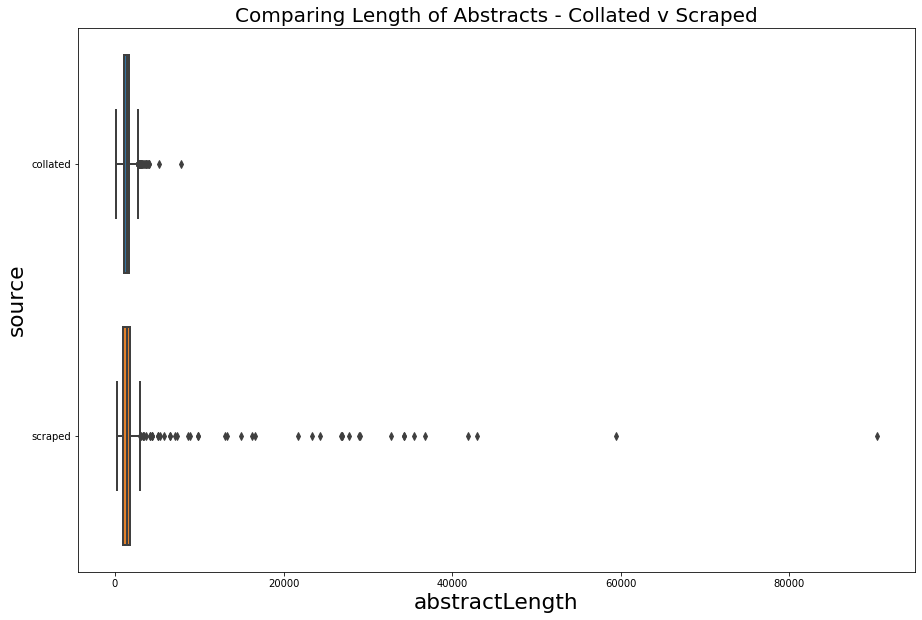

In [200]:
sns.boxplot(y='source', x='abstractLength', data=abstracts)
plt.title('Comparing Length of Abstracts - Collated v Scraped');

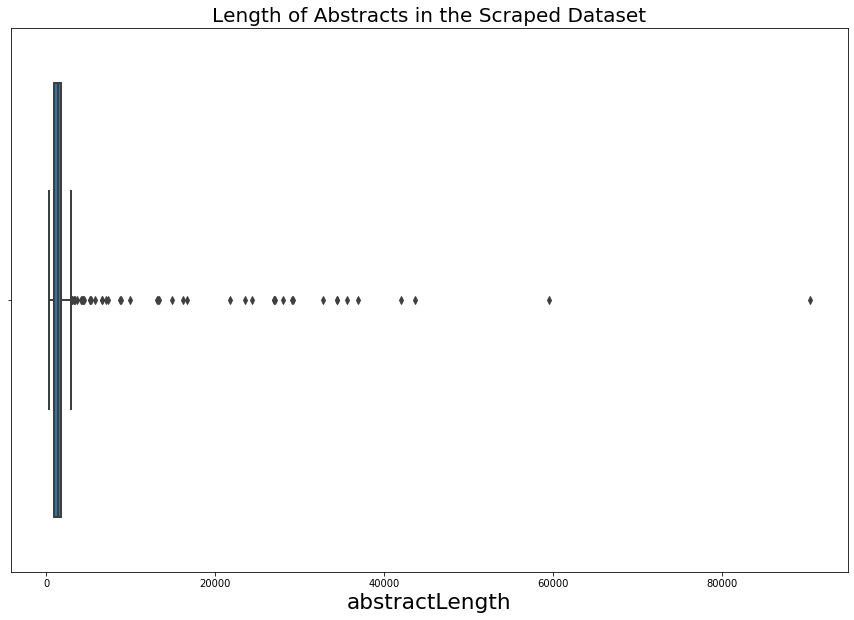

In [201]:
sns.boxplot(x='abstractLength', data=scraped)
plt.title('Length of Abstracts in the Scraped Dataset');

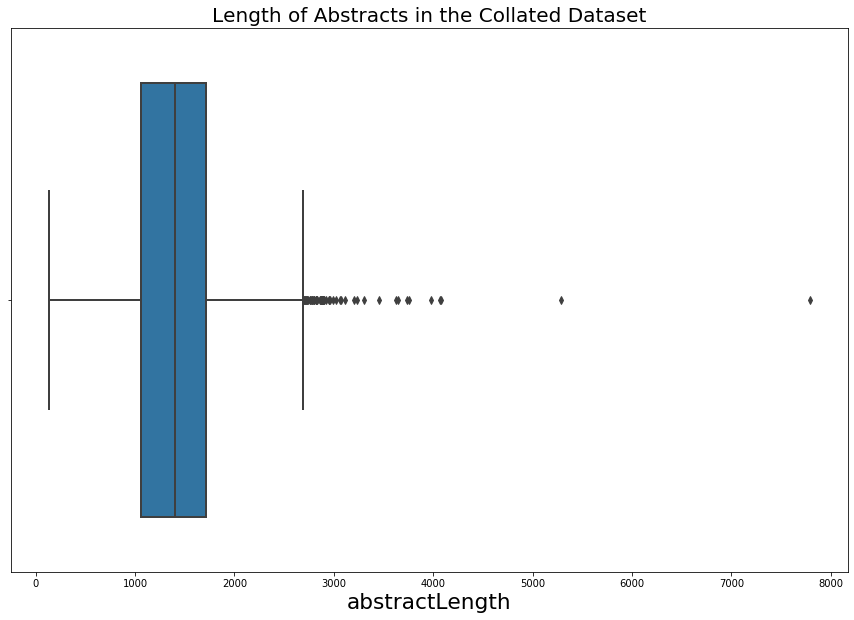

In [202]:
sns.boxplot(x='abstractLength', data=collated)
plt.title('Length of Abstracts in the Collated Dataset');

In [203]:
# Eyeballing these two larger abstracts from the collated dataset online
# confirmed their legitmacy (once references are removed) and sets 5000-8000 as an upper limit of expected length
collated[collated.abstractLength>5000]

,publication,title,authors,doi,year,cites,type,abstract,abstractLength,pubmed,gscholar,crossref,scopus,publicationLanguage,titleLanguage,abstractLanguage,source
4486,online journal of public health informatics,Surveillance for Lyme disease in Canada: 2009-...,"['Jules Koffi', 'Salima Gasmi']",10.5210/ojphi.v11i1.9892,2019.0,1,journal-article,ObjectiveThis study aims to describe incidence...,5289.0,0,0,1,0,en,en,en,collated
4488,online journal of public health informatics,APPLICATION OF INTELLIGENT MULTIAGENT APPROACH...,"['Dmytro Chumachenko', 'Tetyana Chumachenko']",10.5210/ojphi.v11i1.9696,2019.0,0,journal-article,ObjectiveThe objective of this research is to ...,7788.0,0,0,1,0,en,en,en,collated


In [204]:
#Trim the above two abstracts at the references section
for index, row in abstracts[abstracts.publication == 'online journal of public health informatics'].iterrows():
    text= row['abstract']
    text= text[:text.find('References')]
    abstracts.at[index, 'abstract'] = text
    abstracts.at[index, 'abstractLength'] = len(text)

In [205]:
#Create column with just the first part of the DOI to reflect the part that is common accross journals or some repositories. 
abstracts['doiJournal'] = abstracts.doi.apply (lambda x: re.split('/', x)[0])

In [206]:
abstracts[abstracts.abstractLength>5000]

,publication,title,authors,doi,year,cites,type,abstract,abstractLength,pubmed,gscholar,crossref,scopus,publicationLanguage,titleLanguage,abstractLanguage,source,doiJournal
4488,online journal of public health informatics,APPLICATION OF INTELLIGENT MULTIAGENT APPROACH...,"['Dmytro Chumachenko', 'Tetyana Chumachenko']",10.5210/ojphi.v11i1.9696,2019.0,0,journal-article,ObjectiveThe objective of this research is to ...,7135.0,0,0,1,0,en,en,en,collated,10.5210
4893,new england journal of medicine,Two Controlled Trials of Antibiotic Treatment ...,"['Mark S. Klempner', 'Linden T. Hu', 'Janine E...",10.1056/nejm200107123450202,2001.0,465,journal-article,Background It is controversial whether prolong...,34317.0,0,0,1,0,en,en,NaN,scraped,10.1056
4894,new england journal of medicine,Prophylaxis with Single-Dose Doxycycline for t...,"['Robert B. Nadelman', 'John Nowakowski', 'Dur...",10.1056/nejm200107123450201,2001.0,330,journal-article,Background It is unclear whether antimicrobial...,27811.0,0,0,1,0,en,en,NaN,scraped,10.1056
4895,new england journal of medicine,Randomized Trial of Longer-Term Therapy for Sy...,"['Anneleen Berende', 'Hadewych J.M. ter Hofste...",10.1056/nejmoa1505425,2016.0,142,journal-article,Background The treatment of persistent symptom...,35435.0,0,0,1,0,en,en,NaN,scraped,10.1056
4896,new england journal of medicine,Randomized trial of lifestyle modification and...,"[{'name': 'T. Wadden', 'affiliation': 'Univers...",10.1056/nejmoa050156,2005.0,600,Article,Background Weight-loss medications are recomme...,34236.0,0,0,0,1,en,en,NaN,scraped,10.1056
4897,new england journal of medicine,Post-babesiosis warm autoimmune hemolytic anemia,"[{'name': 'A. Woolley', 'affiliation': ""Brigha...",10.1056/nejmoa1612165,2017.0,18,Article,"Background Babesiosis, a tickborne zoonotic di...",23373.0,0,0,0,1,en,en,NaN,scraped,10.1056
4898,new england journal of medicine,Atovaquone and azithromycin for the treatment ...,"['PJ Krause', 'T Lepore', 'VK Sikand', '...']",10.1056/nejm200011163432004,2000.0,327,HTML,"Background Babesiosis is a tick-borne, malaria...",29000.0,0,1,0,0,en,en,NaN,scraped,10.1056
4899,new england journal of medicine,Neighborhood of residence and incidence of cor...,"['AVD Roux', 'SS Merkin', 'D Arnett', '...']",10.1056/nejm200107123450205,2001.0,1821,HTML,Background Where a person lives is not usually...,36754.0,0,1,0,0,en,en,NaN,scraped,10.1056
4900,new england journal of medicine,Neointimal and tubulointerstitial infiltration...,"['PC Grimm', 'P Nickerson', 'J Jeffery', '...']",10.1056/nejm200107123450203,2001.0,318,HTML,Background Tissue remodeling depends on mesenc...,26863.0,0,1,0,0,en,en,NaN,scraped,10.1056
4901,new england journal of medicine,Itraconazole to prevent fungal infections in c...,"['JI Gallin', 'DW Alling', 'HL Malech', 'R Wes...",10.1056/nejmoa021931,2003.0,375,HTML,Background Chronic granulomatous disease is a ...,26897.0,0,1,0,0,en,en,NaN,scraped,10.1056


#### Handling Outliers in Batches

In [207]:
for index, row in abstracts[abstracts.publication == 'new england journal of medicine'].iterrows():
    text= row['abstract']
    text= text[:text.find('Introduction')]
    abstracts.at[index, 'abstract'] = text
    abstracts.at[index, 'abstractLength'] = len(text)

In [208]:
for index, row in abstracts[abstracts.doiJournal== '10.1155'].iterrows():
    text= row['abstract']
    text= text[:text.find('1. ')]
    abstracts.at[index, 'abstract'] = text
    abstracts.at[index, 'abstractLength'] = len(text)

In [209]:
for index, row in abstracts[abstracts.publication == 'actual infectology'].iterrows():
    text= row['abstract']
    text= text[text.find('Abstract')+8:text.find('Introduction')]
    abstracts.at[index, 'abstract'] = text
    abstracts.at[index, 'abstractLength'] = len(text)

In [210]:
for index, row in abstracts[abstracts.publication == 'epidemiology: open access'].iterrows():
    text= row['abstract']
    text= text[:text.find('Keywords')]
    abstracts.at[index, 'abstract'] = text
    abstracts.at[index, 'abstractLength'] = len(text)

In [211]:
for index, row in abstracts[abstracts.publication == 'actual infectology'].iterrows():
    text= row['abstract']
    text= text[text.find('Abstract')+8:text.find('Introduction')]
    abstracts.at[index, 'abstract'] = text
    abstracts.at[index, 'abstractLength'] = len(text)

In [212]:
#Remaining outliers longer than 5000 characters
abstracts[abstracts.abstractLength>5000]

,publication,title,authors,doi,year,cites,type,abstract,abstractLength,pubmed,gscholar,crossref,scopus,publicationLanguage,titleLanguage,abstractLanguage,source,doiJournal
4488,online journal of public health informatics,APPLICATION OF INTELLIGENT MULTIAGENT APPROACH...,"['Dmytro Chumachenko', 'Tetyana Chumachenko']",10.5210/ojphi.v11i1.9696,2019.0,0,journal-article,ObjectiveThe objective of this research is to ...,7135.0,0,0,1,0,en,en,en,collated,10.5210
5084,dmw - deutsche medizinische wochenschrift,Lyme-Borreliose: Wie kann das Erythema migrans...,"['J Schröder', 'W Kirch']",10.1055/s-0029-1242694,2009.0,0,journal-article,Buy Article Permissions and Reprints Mittel de...,6591.0,0,0,1,0,de,de,NaN,scraped,10.1055
5264,actual infectology,Lyme disease in childhood: look at the problem...,"['T.V. Sorokman', 'P.M. Moldovan']",10.22141/2312-413x.6.1.2018.125628,2018.0,0,journal-article,ture review considers the problem of Lyme di­s...,6441.0,0,0,1,0,ro,en,NaN,scraped,10.22141
5367,biomedical journal of scientific & technical r...,Missed Diagnosis and the Development of Acute ...,['James R Palmieri'],10.26717/bjstr.2019.21.003583,2019.0,1,journal-article,Background: Lyme Disease (LD) is the most com...,32690.0,0,0,1,0,en,en,NaN,scraped,10.26717
5510,journal of osteopathic medicine,Evaluating the patient with peripheral nervous...,"['K Scott', 'MJ Kothari']",10.7556/jaoa.2005.105.2.71,2005.0,13,HTML,Patients commonly seek care from their family...,59492.0,0,1,0,0,en,en,NaN,scraped,10.7556
5627,seminars in neurology,Multiple cranial neuropathies,"['CG Carroll', 'WW Campbell']",10.1055/s-0028-1124023,2009.0,46,HTML,Patients presenting with multiple cranial neur...,9861.0,0,1,0,0,af,ro,NaN,scraped,10.1055
5666,zfa - zeitschrift für allgemeinmedizin,Die Lyme-Borreliose,['D. Hassler'],10.1055/s-2006-958722,2007.0,0,journal-article,Buy Article Permissions and Reprints Zusammenf...,8721.0,0,0,1,0,de,af,NaN,scraped,10.1055
5686,acta medica martiniana,Lyme Borreliosis - Risk of Occupational Infection,"['Maria Bochnickova', 'Maria Szilagyiova']",10.2478/v10201-011-0016-6,2011.0,1,journal-article,References Recent Articles Journal & Issue Det...,5869.0,0,0,1,0,ro,en,NaN,scraped,10.2478
5711,pediatría atención primaria,Enfermedad de Lyme: a propósito de dos casos,"['A. Pérez Guirado', 'R. I. Fernández Fernánde...",10.4321/s1139-76322013000400012,2013.0,3,journal-article,My SciELO Custom services Services on Demand J...,16669.0,0,0,1,0,es,es,NaN,scraped,10.4321
5762,arthritis und rheuma,Lyme-Arthritis,['F. Dressler'],10.1055/s-0038-1660941,2018.0,0,journal-article,Buy Article Permissions and Reprints Zusammenf...,5301.0,0,0,1,0,en,en,NaN,scraped,10.1055


In [213]:
#These outliers were handled individually

#Trimmed
#-------
abstracts.at[5367, 'abstract'] = abstracts.loc[5367].abstract[abstracts.loc[5367].abstract.find(
    'Background'): abstracts.loc[5367].abstract.find('Lyme Disease Defined')]
abstracts.at[5367, 'abstractLength'] =len(abstracts.loc[5367].abstract)

abstracts.at[5510, 'abstract'] = abstracts.loc[5510].abstract[abstracts.loc[5510].abstract.find(
    'Patients'): abstracts.loc[5510].abstract.find('Clinical Presentation')]
abstracts.at[5510, 'abstractLength'] =len(abstracts.loc[5510].abstract)

abstracts.at[5627, 'abstract'] = abstracts.loc[5627].abstract[: abstracts.loc[5627].abstract.find('KEYWORDS')]
abstracts.at[5627, 'abstractLength'] =len(abstracts.loc[5627].abstract)

abstracts.at[5686, 'abstract'] = abstracts.loc[5686].abstract[abstracts.loc[5686].abstract.find(
    'Lyme'): abstracts.loc[5686].abstract.find('Keywords')]
abstracts.at[5686, 'abstractLength'] =len(abstracts.loc[5686].abstract)

abstracts.at[5806, 'abstract'] = abstracts.loc[5806].abstract[abstracts.loc[5806].abstract.find(
    'Borreliosis'): abstracts.loc[5806].abstract.find('Keywords')]
abstracts.at[5806, 'abstractLength'] =len(abstracts.loc[5806].abstract)

abstracts.at[5808, 'abstract'] = abstracts.loc[5808].abstract[abstracts.loc[5808].abstract.find(
    'Babesia'): abstracts.loc[5808].abstract.find('Introduction')]
abstracts.at[5808, 'abstractLength'] =len(abstracts.loc[5808].abstract)

# Removed
# -------
abstracts.drop(index=5084, inplace=True) #Non English
abstracts.drop(index=5666, inplace=True) #Non English
abstracts.drop(index=5711, inplace=True) #Non English
abstracts.drop(index=5762, inplace=True) #Non English
abstracts.drop(index=5765, inplace=True) #Non English
abstracts.drop(index=5817, inplace=True) #Non English
abstracts.drop(index=5889, inplace=True) #Non English
abstracts.drop(index=5785, inplace=True) #Course Material - Not an abstract

# Keeping track of numbers removed 
NonEnglish = 7
nonJournal = 1

In [214]:
#Remaining outliers longer than 5000 characters
abstracts[abstracts.abstractLength>5000]

,publication,title,authors,doi,year,cites,type,abstract,abstractLength,pubmed,gscholar,crossref,scopus,publicationLanguage,titleLanguage,abstractLanguage,source,doiJournal
4488,online journal of public health informatics,APPLICATION OF INTELLIGENT MULTIAGENT APPROACH...,"['Dmytro Chumachenko', 'Tetyana Chumachenko']",10.5210/ojphi.v11i1.9696,2019.0,0,journal-article,ObjectiveThe objective of this research is to ...,7135.0,0,0,1,0,en,en,en,collated,10.5210
5264,actual infectology,Lyme disease in childhood: look at the problem...,"['T.V. Sorokman', 'P.M. Moldovan']",10.22141/2312-413x.6.1.2018.125628,2018.0,0,journal-article,ture review considers the problem of Lyme di­s...,6441.0,0,0,1,0,ro,en,NaN,scraped,10.22141


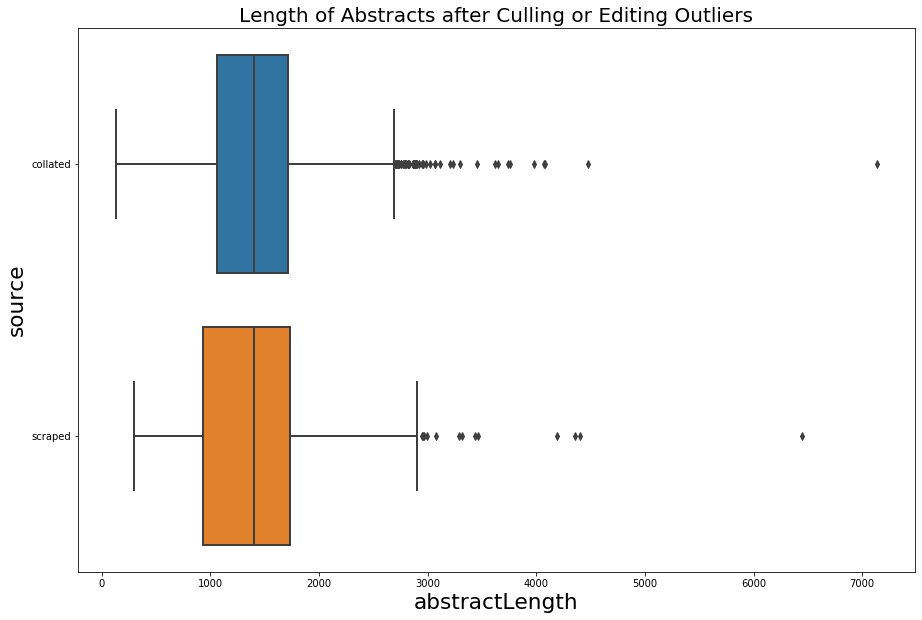

In [215]:
sns.boxplot(y='source', x='abstractLength', data=abstracts)
plt.title('Length of Abstracts after Culling or Editing Outliers');

In [216]:
oldtotal = total
total = len(abstracts)+nonJournal+NonEnglish 
# These two extra variables acccount in the total equation above account for 
# records removed at earlier stages of the process.

print("Records with existing abstracts:", len(collated))
print("Abstracts sought via scraping :", toScrape)
print("Abstracts successfully scraped:", total-len(collated))
print('Size of new dataset:', total)
print('Records not retrieved:', oldtotal-total)

Records with existing abstracts: 4615
Abstracts sought via scraping : 4125
Abstracts successfully scraped: 1282
Size of new dataset: 5897
Records not retrieved: 2843


## Assessing All Abstracts for Eligibility

### Removing Non-English Abstracts 

<p>Only English language abstracts are relevant to this analysis so the langdetect package is used to determine the most likely language of an abstract. Altogether, 66 non-English records were removed.</p>

In [217]:
abstracts['abstractLanguage']=abstracts.abstract.apply(detect)

In [218]:
abstracts.abstractLanguage.value_counts(dropna=False)

en    5830
de      40
hr       6
pt       3
es       3
hu       2
no       2
da       1
pl       1
bg       1
Name: abstractLanguage, dtype: int64

In [219]:
#restrict to English abstracts
abstracts=abstracts[abstracts.abstractLanguage=='en']

In [220]:
abstracts.abstractLanguage.value_counts(dropna=False)

en    5830
Name: abstractLanguage, dtype: int64

In [221]:
oldtotal = total
total = len(abstracts)+nonJournal 

print('Abstracts analysed for language:', oldtotal)
print('Records with Non-English abstracts removed:', oldtotal-total)
print('Records with English abstracts remaining:', total)

Abstracts analysed for language: 5897
Records with Non-English abstracts removed: 66
Records with English abstracts remaining: 5831


### Removing Records with no Relevant Terms in Title or Abstract

<p>To ensure only abstracts that are relevant to the area of study are included, the title and abstract of each record are matched against a number of key terms related to Lyme and tick-borne disease. Any record that does not include at least one key term in either its title or abstract text can confidently be removed.</p>
<p>A total of 189 records were removed at this point.</p>

In [222]:
terms = 'Lyme|Borrel(\w+)|burgdorferi|Ixodes|Erythema|migrans|tick-borne|tickborne|tick borne'
notRelevant = abstracts[~(abstracts['abstract'].str.contains(terms,flags=re.IGNORECASE) | abstracts['title'].str.contains(terms,flags=re.IGNORECASE))]

/Users/myfriendscallmej/anaconda3/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [223]:
#A text file of records removed at this point is kept for later inspection.

#open text file
text_file = open("excludedForRelevance.txt", "w")
 
for index, row in notRelevant.iterrows():
    string = (str(index) + ' http://dx.doi.org/'+row.doi + '\n' + row.title + '\n' + row.abstract + '\n\n')
    text_file.write(string)
    
text_file.close()
del notRelevant

In [224]:
abstracts = abstracts[(abstracts['abstract'].str.contains(terms,flags=re.IGNORECASE) | abstracts['title'].str.contains(terms,flags=re.IGNORECASE))]

/Users/myfriendscallmej/anaconda3/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [225]:
oldtotal = total
total = len(abstracts)+nonJournal 

print('Records analysed for relevance:', oldtotal)
print('Records removed for having no matching keywords:', oldtotal-total)
print('Records remaining:', total)

Records analysed for relevance: 5831
Records removed for having no matching keywords: 189
Records remaining: 5642


### Removing Non-Journal Abstracts 

<p>One record that was course material was found when looking at length outliers. That record was removed then but should be highlighted now as part of the screening at this stage.</p>

In [226]:
oldtotal = total
total = len(abstracts)

print('Records removed due to being course material:', oldtotal-total)
print('Records with abstracts remaining:', total)

Records removed due to being course material: 1
Records with abstracts remaining: 5641


## Saving Complete Dataset

In [227]:
abstracts.reset_index(drop=True, inplace=True)

In [230]:
abstracts.to_csv('abstracts.csv')